# Training Job
#### In this notebook we will focus on reading the data that we pre-processed previouslly and then start training

In [1]:
import boto3
import sagemaker
from sagemaker import get_execution_role

region = boto3.session.Session().region_name
role = get_execution_role()

## 1. Reading Data 

In [2]:
import argparse
import os
import warnings

import pandas as pd
import pathlib
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


In [3]:
features_loc = "pre-processed data/"

spectrogram_ds = tf.data.experimental.load(features_loc + "train/")
val_ds = tf.data.experimental.load(features_loc + "val/")
test_ds = tf.data.experimental.load(features_loc + "test/")
commands = np.load(features_loc + "labels/commands.npy")

In [4]:
val_ds

<_LoadDataset shapes: ((None, 129, 1), ()), types: (tf.float32, tf.int64)>

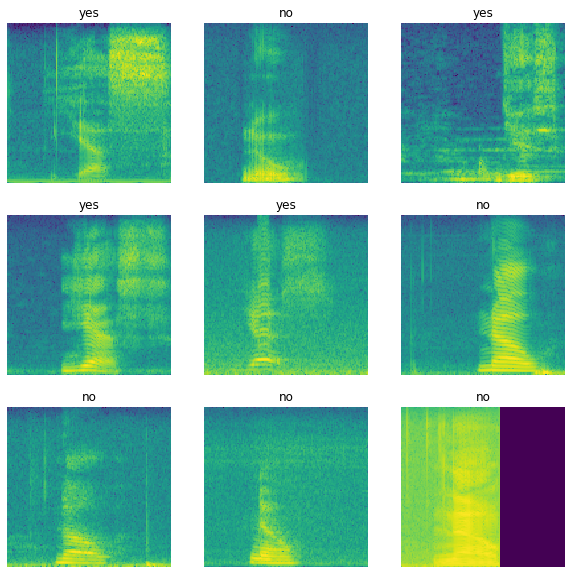

In [5]:
import matplotlib.pyplot as plt
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [6]:
%%writefile utils/train.py

    
import argparse
import os
import warnings

import pandas as pd
import pathlib
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

if __name__ =='__main__':

    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument('--epochs', type=int, default=10)
    parser.add_argument('--batch_size', type=int, default=64)

    # input data and model directories
    parser.add_argument('--model_dir', type=str)
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--val', type=str, default=os.environ.get('SM_CHANNEL_VAL'))
    parser.add_argument('--test', type=str, default=os.environ.get('SM_CHANNEL_TEST'))    
    parser.add_argument('--labels', type=str, default=os.environ.get('SM_CHANNEL_LABELS'))


    args, _ = parser.parse_known_args()
    
    spectrogram_ds = tf.data.experimental.load(args.train)
    train_ds = spectrogram_ds
    val_ds = tf.data.experimental.load(args.val)
    test_ds = tf.data.experimental.load(args.test)
    commands = np.load(args.labels + "/commands.npy")
    
    batch_size = args.batch_size
    train_ds = train_ds.batch(batch_size)
    val_ds = val_ds.batch(batch_size)
    
    
    #Add Dataset.cache and Dataset.prefetch operations to reduce read latency while training the model:
    
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().prefetch(AUTOTUNE)
    val_ds = val_ds.cache().prefetch(AUTOTUNE)
    
    
    #For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

    # Your tf.keras.Sequential model will use the following Keras preprocessing layers:
    # - tf.keras.layers.Resizing: to downsample the input to enable the model to train faster.
    # - tf.keras.layers.Normalization: to normalize each pixel in the image based on its mean and standard deviation.
    # - For the Normalization layer, its adapt method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).
    
    
    for spectrogram, _ in spectrogram_ds.take(1):
      input_shape = spectrogram.shape
    print('Input shape:', input_shape)
    num_labels = len(commands)
    print(num_labels)
    
    for spectrogram, _ in val_ds.take(1):
      tmp = spectrogram.shape
    print('val shape:', tmp)

    # Instantiate the `tf.keras.layers.Normalization` layer.
    norm_layer = layers.Normalization()
    # Fit the state of the layer to the spectrograms
    # with `Normalization.adapt`.
    norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

    model = models.Sequential([
        layers.Input(shape=input_shape),
        # Downsample the input.
        layers.Resizing(32, 32),
        # Normalize.
        norm_layer,
        layers.Conv2D(32, 3, activation='relu'),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_labels),
    ])

    print(model.summary())
    
    #     Configure the Keras model with the Adam optimizer and the cross-entropy loss:
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )
    
    EPOCHS = args.epochs
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
    )

    
    # Save model to the SM_MODEL_DIR path
    print("Saving model to {}".format(os.environ.get('SM_MODEL_DIR')))
    model.save(os.environ.get('SM_MODEL_DIR'))
    



Overwriting utils/train.py


# Creating the Training Job

In [7]:
! pip install -U sagemaker

You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.


In [8]:
from sagemaker.tensorflow import TensorFlow
from sagemaker.debugger import TensorBoardOutputConfig


tensorboard_output_config = TensorBoardOutputConfig(
       s3_output_path = 's3://sagemaker-studio-062044820001-7qbctb3w94p/Training/tensorboard_log_folder/'
)



tf_estimator = TensorFlow(
        entry_point="utils/train.py",
        role=role,
        instance_count=1,
        instance_type="ml.m5.large",
        framework_version="2.6",
        py_version="py38",
        tensorboard_output_config=tensorboard_output_config,
        output_path = "s3://sagemaker-studio-062044820001-7qbctb3w94p/Training/models/"
    )

data_path = "s3://sagemaker-studio-062044820001-7qbctb3w94p/Datasets/mini-speech-commands/pre-processed/"

tf_estimator.fit({'train': data_path + "train/",
                  'val': data_path + "val/",
                  'test': data_path + "test/",
                  'labels': data_path + "commands/"})

2022-03-24 14:47:50 Starting - Starting the training job...
2022-03-24 14:48:13 Starting - Preparing the instances for trainingProfilerReport-1648133270: InProgress
.........
2022-03-24 14:49:34 Downloading - Downloading input data......
2022-03-24 14:50:34 Training - Downloading the training image...
2022-03-24 14:51:15 Training - Training image download completed. Training in progress..2022-03-24 14:51:18.388996: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-03-24 14:51:18.396548: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2022-03-24 14:51:18.504210: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-03-24 14:51:21,354 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2022-03-24 14:51:

In [9]:
! tensorboard --logdir 's3://sagemaker-studio-062044820001-7qbctb3w94p/Training/tensorboard_log_folder/'

2022-03-24 14:58:55.831220: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-03-24 14:58:55.831348: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2022-03-24 14:58:55.857509: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
Exception in thread Reloader:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.8/site-packages/tensorboard/backend/event_processing/data_ingester.py", line 98, in _reload
    self._multiplexer.AddRunsFromDirectory(path, name)
  File "/usr/local/lib/python3.8/site-packages/tensorboard/backend/event_process